In [1]:
%matplotlib inline

from collections import defaultdict
from queue import Queue

import matplotlib.pyplot as plt
import numpy as np
import os

import pickle
import time

from random import shuffle

In [16]:
switch_literal = lambda x: x[1:] if x.startswith('-') else '-'+x
deepcopy = lambda x: pickle.loads(pickle.dumps(x))

def parse_input(input_file):
    
    """
    literal_clauseNum: {Literal: Set of clause numbers that are still in consideration for this variable}                        
    
    clauseNum_clause: {Clause number: Set of literals that could still satisfy this clause}
    
    literal_boolen: {Literal: boolean on whether literal set of True/False/None, None meaning could be either, doesn't matter}
    
    input_file:
    c DIMACS CNF: conjunction/AND of one or more clauses, where a clause is a disjunction/OR of literals
    c Comments start with a c, First lines begins with p and describes the probelm and all clause lines end with a 0
    c Can't have same variable in both forms in same clause. So A ~A is not allowed. Can have them in separate clauses.
                        
    """

    all_clauses = []  # List of all clauses that appear in input. Used for SAT checking the mapping given by DPLL

    literal_clauseNum = defaultdict(set)

    def filler():
        return None

    literal_boolen = defaultdict(filler)

    clauseNum_clause = {}

    clause_counter = 0

    with open(input_file, 'r') as fin:
        for line in fin:
            line = line.strip()
            # Do checks on comments
            if line.startswith('c') or line.startswith('p') or line.startswith('0') or line.startswith('%'):
                continue
            if len(line) > 0:
                clause = []
                clause_counter += 1
                for literal in line.split():
                    if literal == '0':
                        # End of line, ignore in DIMACS CNF format
                        continue
                    clause.append(literal)
                    literal_clauseNum[literal].add(clause_counter)
                clauseNum_clause[clause_counter] = set(clause)
                all_clauses.append(clause)

    return literal_clauseNum, clauseNum_clause, literal_boolen, all_clauses

def unit_prop(literal_clauseNum, clauseNum_clause, literal_boolen):
    keep_updating = True
    while keep_updating:
        keep_updating = False # Assuming we've found all unit clauses
        for clauseNum in list(clauseNum_clause.keys()):
            if clauseNum not in clauseNum_clause:
                continue
            clause = clauseNum_clause[clauseNum]
            # Clause contains the remaining literals that could potentially satisfy this clause. 
            if len(clause) == 0:
                # Empty clause, so need to return True for empty clause detected
                return True, None, None, None
            if len(clause) > 1:
                # Can't do unit prop 
                continue

            literal = clause.pop()  # Needs to be set to True
            clause.add(literal)  # Removed later
            literal_boolen[literal] = True
            keep_updating = True  # Since we found one unit clause, maybe more

    #         print(literal)
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)

            # For all clauses that have this literal, they have been satisfied now
            # 1) Gather all pairs of (literals, clauseNum) that appear in these clauses so we can remove them from literal_clauseNum
            # 2) Delete these clauses from clauseNum_clause
            pairs_to_delete = []
            for clauseNums_with_literal in literal_clauseNum[literal]:
                for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
                    pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

    #         print(pairs_to_delete)

            for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
                literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
                if clauseNums_with_literal in clauseNum_clause:
                    del clauseNum_clause[clauseNums_with_literal]

            # For all the clauses with opposite literal, remove the literal from the clause
            if switch_literal(literal) not in literal_clauseNum: # if the opposite variable doesn't exist, skip
                continue

            opposite_literal = switch_literal(literal)
            literal_boolen[opposite_literal] = False

            for clauseNums_with_literal in literal_clauseNum[opposite_literal]:
                clauseNum_clause[clauseNums_with_literal].discard(opposite_literal)

            literal_clauseNum[opposite_literal] = set()  # It is not watching any clauses anymore

    #         print("OPPO")
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)
        
    return False, literal_clauseNum, clauseNum_clause, literal_boolen


def pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen):
    for literal in list(literal_clauseNum.keys()):
        if literal in literal_boolen:
            continue
        
        opposite_literal = switch_literal(literal)
        if opposite_literal not in literal_boolen: # The opposite variable has not been assigned yet
            # If it doesn't exist or it does but it doesn't have to satisfy any clauses
            if opposite_literal not in literal_clauseNum or len(literal_clauseNum[opposite_literal]) == 0:
                # LITERAL IS A PURE LITERAL
                literal_boolen[literal] = True
                
                # All the clauses that literal exists in has been made true, so remove the clauses and make literal watch no clause
                pairs_to_delete = []
                for clauseNums_with_literal in literal_clauseNum[literal]:
                    for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
                        pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

        #         print(pairs_to_delete)

                for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
                    literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
                    if clauseNums_with_literal in clauseNum_clause:
                        del clauseNum_clause[clauseNums_with_literal]
                        
    return literal_clauseNum, clauseNum_clause, literal_boolen


def maxo(literal_clauseNum, return_counts=False):
    """
    Returns the literal that appears in the most number of clauses
    """
    literal_count = defaultdict(int)
    for literal, clauseNums in literal_clauseNum.items():
        literal_count[literal] = len(clauseNums)
    if return_counts:
        return literal_count
    
    max_lit = None
    max_count = 0
    for literal, count in literal_count.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    return max_lit, max_count


def moms(literal_clauseNum, clauseNum_clause, return_counts=False):
    """
    Returns the literal that appears most in the smallest clauses
    """
    # Select the clausesNumbers for clauses of the smaller size
    least_size = min(map(len, clauseNum_clause.values()))
    literal_count = defaultdict(int)
    
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            if len(clauseNum_clause[clauseNum]) == least_size:
                # Each time a literal appears in a least-size clause we 
                # increment counter by 1
                literal_count[literal] += 1
    
    if return_counts:
        return literal_count
    
    max_lit = None
    max_count = 0
    for literal, count in literal_count.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    return max_lit, max_count


def mams(literal_clauseNum, clauseNum_clause):
    """
    Combines MAXO and MOMS count statistics from above and chooses the literal that appears most between them
    """
    maxo_ans = maxo(literal_clauseNum, return_counts=True)
    moms_ans = moms(literal_clauseNum, clauseNum_clause, return_counts=True)
    
    # MAXO would return the dict with most keys
    for literal in maxo_ans:
        maxo_ans[literal] += moms_ans[literal]
        # Since using defaultdict we add 0 if literal not in moms_ans
    
    max_lit = None
    max_count = 0
    for literal, count in maxo_ans.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    
    return max_lit, max_count


def jw(literal_clauseNum, clauseNum_clause):
    """
    Jeroslow-Wang Rule
    """
    literal_score = defaultdict(int)
    
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            clause = clauseNum_clause[clauseNum]
            literal_score[literal] += 2 ** -len(clause)
    
    max_lit = None
    max_score = 0
    for literal, score in literal_score.items():
        if score > max_score:
            max_score = score
            max_lit = literal
            
    return max_lit, max_score

def jw_2(literal_clauseNum, clauseNum_clause):
    """
    2-sided JW rule. See Heutistics folder
    """
    
    literal_score = defaultdict(int)
    
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            clause = clauseNum_clause[clauseNum]
            literal_score[literal] += 2 ** -len(clause)
    
    max_lit = None
    max_score = 0
    for literal, score in list(literal_score.items()):
        other_literal = switch_literal(literal)
        total_score = score + literal_score[other_literal]
        
        if total_score > max_score:
            max_score = score
            max_lit = literal if score >= literal_score[other_literal] else other_literal
            
    return max_lit, max_score


def bohm(literal_clauseNum, clauseNum_clause):
    """
    See Heuristics folder. Lexicographic order of the vector (H1(x), H2(x), ..., Hn(x)) means we first choose highest H1(x)
    variable. When tied we then choose amongst tied variable highest H2 variable. When tied then H3 and so on.
    
    We've had to manage edge cases here but don't mention that in report. Only give formula from paper
    """
    pos_literal_count = defaultdict(lambda: [0, 0, 0])  # This default initialisation only works for 3 SAT
    neg_literal_count = defaultdict(lambda: [0, 0, 0])
    
    for literal, clauseNums in literal_clauseNum.items():
        if literal.startswith('-'):
            for clauseNum in clauseNums:
                clause = clauseNum_clause[clauseNum]
                neg_literal_count[literal][len(clause)-1] += 1
        else:
            for clauseNum in clauseNums:
                clause = clauseNum_clause[clauseNum]
                pos_literal_count[literal][len(clause)-1] += 1
                
    final_count = []
    # Sometimes we only have negative literals left. So then we just use those
    for literal, pos_counts in (pos_literal_count.items() or neg_literal_count.items()):
        other_literal = switch_literal(literal)
        
        if literal.startswith('-'):
            # pos_literal_counts is empty. So literal and pos_counts actually are neg_literal_counts
            neg_counts = pos_literal_count[other_literal]
        else:
            # pos_literal_counts isn't empty. So continue as normal
            neg_counts = neg_literal_count[other_literal]
        
        final_count.append(([max(p, n) + 2 * min(p, n) for p, n in zip(pos_counts, neg_counts)], literal))
            
    final_count.sort(reverse=True)
    score_vector, literal = final_count[0]
    other_literal = switch_literal(literal)
    
    if literal.startswith('-'):
        neg_literal = literal
        pos_literal = other_literal
    else:
        neg_literal = other_literal
        pos_literal = literal
    
    # Since the score for positive and negative literal is the same, choose one which the highest overall score
    if sum(pos_literal_count[pos_literal]) >= sum(neg_literal_count[neg_literal]):
        literal = pos_literal
    else:
        literal = neg_literal
    
    return literal, score_vector
    

def set_var(literal, boolean, literal_clauseNum, clauseNum_clause, literal_boolen):
    literal_boolen[literal] = boolean

    if boolean == False:
        literal = switch_literal(literal)
        literal_boolen[literal] = True
    
    # Unit-prop logic below
    pairs_to_delete = []
    for clauseNums_with_literal in literal_clauseNum[literal]:
        for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
            pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

    #         print(pairs_to_delete)

    for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
        literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
        if clauseNums_with_literal in clauseNum_clause:
            del clauseNum_clause[clauseNums_with_literal]

    # For all the clauses with opposite literal, remove the literal from the clause
    if switch_literal(literal) not in literal_clauseNum: # if the opposite variable doesn't exist, skip
        return literal_clauseNum, clauseNum_clause, literal_boolen

    opposite_literal = switch_literal(literal)
    literal_boolen[opposite_literal] = False

    for clauseNums_with_literal in literal_clauseNum[opposite_literal]:
        clauseNum_clause[clauseNums_with_literal].discard(opposite_literal)

    literal_clauseNum[opposite_literal] = set()  # It is not watching any clauses anymore

    #         print("OPPO")
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)
    
    return literal_clauseNum, clauseNum_clause, literal_boolen

def choose_var(literal_clauseNum, clauseNum_clause, literal_boolen, algo='maxo'):
    # Choosing the first literal every time
#     remaining_clauses = list(clauseNum_clause.values())
#     literal = remaining_clauses[0].pop()
#     remaining_clauses[0].add(literal)

    # Using heuristics
    if algo == 'maxo':
        literal, _ = maxo(literal_clauseNum)
    elif algo == 'moms':
        literal, _ = moms(literal_clauseNum, clauseNum_clause)
    elif algo == 'mams':
        literal, _ = mams(literal_clauseNum, clauseNum_clause)
    elif algo == 'jw':
        literal, _ = jw(literal_clauseNum, clauseNum_clause)
    elif algo == 'jw_2':
        literal, _ = jw_2(literal_clauseNum, clauseNum_clause)
    elif algo == 'bohm':
        literal, _ = bohm(literal_clauseNum, clauseNum_clause)
    

    return literal

In [126]:
# Methods that are used by the Env class to get state features

def number_of_variables(literal_clauseNum):
    """ Returns the number of total variables (including repeats) present in the remaining clauses """
    return sum(map(len, literal_clauseNum.values()))


def horn_clause_ratio(clauseNum_clause):
    """ Returns the ratio of horn clauses to total number of clauses """
    horn_count = 0
    total_count = 0
    for clause in clauseNum_clause.values():
        if len(clause) > 0:
            total_count += 1
        if len(list(filter(lambda x: not x.startswith('-'), clause))) == 1:
            horn_count = 0

    return horn_count / total_count if total_count > 0 else 0


def clause_to_variable_ratio(literal_clauseNum):
    """ Returns the clause to variable ratio: c/v which predict problem hardness """
    clauses = set()
    num_literals = 0
    for literal, clauseNums in literal_clauseNum.items():
        if len(clauseNums) > 0:
            clauses = clauses.union(clauseNums)
            if literal.startswith('-'):
                num_literals += 1
            else:
                num_literals += 1

    return 0 if num_literals == 0 else len(clauses) / num_literals


def pos_neg_ratio(literal_clauseNum):
    """
    Returns the number of positive literals (incl repeats) to negative literals (incl repeats) in the clauses.
    THIS DOESN'T GIVE USEFUL STATE INFORMATION WHEN USED ALONE
    """
    pos_literal_count = 0
    neg_literal_count = 0

    for literal, clauseNums in literal_clauseNum.items():
        if literal.startswith('-'):
            neg_literal_count += len(clauseNums)
        else:
            pos_literal_count += len(clauseNums)

    return pos_literal_count / neg_literal_count if neg_literal_count > 0 else pos_literal_count


def CVIG(literal_clauseNum, clauseNum_clause):
    """
    Caluse-variable incidence graph. We create a bipartite graph (a matrix) with literals in columns and clauses in rows.
    See Features_2 PDF file.
    """
    if len(clauseNum_clause) == 0:
        return 0
    
    literal_index_mapping = {}
    clauseNum_index_mapping = {}
    
    for i, literal in enumerate(literal_clauseNum.keys()):
        literal_index_mapping[literal] = i
        
    for i, clauseNum in enumerate(clauseNum_clause):
        clauseNum_index_mapping[clauseNum] = i
    
    graph = np.zeros((len(literal_index_mapping), len(clauseNum_clause)))
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            graph[literal_index_mapping[literal]] [clauseNum_index_mapping[clauseNum]] = 1/len(clauseNums)
    
    return np.mean(graph)

In [122]:
env = Env('../Tests/SATLIB_20/uf20-026.cnf')
print(env.reset())
while True:
    _, _, done = env.step(4)
    if done:
        break
    print(env.get_state())
#     a, b, c = env.state
#     print(jw_2(a, b))

0.01098901098901099
0.01144578313253012
0.012162162162162163
0.013114754098360656
0.015625
0.016666666666666666
0.018055555555555554
0.018055555555555554


In [123]:
class Env:
    
    def __init__(self, input_file):
        self.input_file = input_file
        self.stack = [] # We use a stack to hold the next states to explore. i.e. we do DFS as less memory requirements than BFS
        self.state = None
        self.actions = {0: 'maxo', 1: 'moms', 2: 'mams', 3: 'jw', 4: 'jw_2', 5: 'bohm'}
    
    def reset(self):
        # Returns state
        literal_clauseNum, clauseNum_clause, literal_boolen, _ = parse_input(self.input_file)
        self.state = (literal_clauseNum, clauseNum_clause, literal_boolen)
        return self.get_state()
    
    def get_state(self):
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        
        num_var = number_of_variables(literal_clauseNum)
        horn_clause = horn_clause_ratio(clauseNum_clause)
        c_v_ratio = clause_to_variable_ratio(literal_clauseNum)
        cvig_mean = CVIG(literal_clauseNum, clauseNum_clause)
        
        return [num_var, horn_clause, c_v_ratio, cvig_mean]
    
    def step(self, action):
        """
        Returns: next_state_1, next_state_2, reward, done
        reward = 0 if reached a leaf node, 0 if not
        """
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        
        unassigned_nodes_start = len(list(filter(lambda x: len(x) > 0, literal_clauseNum.values())))
        
        # Do unit prop
        empty_clause, literal_clauseNum, clauseNum_clause, literal_boolen = \
            unit_prop(literal_clauseNum, clauseNum_clause, literal_boolen)
            
        if empty_clause:
            isEmpty = len(self.stack) == 0
            if not isEmpty:
                self.state = self.stack.pop()
            return 0, -1, isEmpty
        
        if clauseNum_clause == {}:
            return 0, 0, True
        
        # Do pure literal elimination
        literal_clauseNum, clauseNum_clause, literal_boolen = \
            pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen)
            
        if clauseNum_clause == {}:
            return 0, 0, True
        
        literal = choose_var(literal_clauseNum, clauseNum_clause, literal_boolen, algo=self.actions[action])
        
        # Set the chosen literal to be True
        literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T = \
            set_var(literal, True, deepcopy(literal_clauseNum), deepcopy(clauseNum_clause), dict(literal_boolen))
            
#         print("After setting", literal, "to True")
#         print(literal_clauseNum_T)
#         print(literal_boolen_T)
#         print()
        
#         unassigned_nodes_T = len(filter(lambda x: len(x) > 0, literal_clauseNum_T.values()))
        
#         # Do unit prop and pure literal elimnation and record the number of nodes assigned
#         empty_clause, literal_clauseNum, clauseNum_clause, literal_boolen = 
#             unit_prop(literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T)
        
#         if empty_clause:
#             return 0, 0, unassigned_nodes_start, self.q.empty()
        
#         # Do pure literal elimination
#         literal_clauseNum, clauseNum_clause, literal_boolen = 
#             pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         if clauseNum_clause == {}:
#             return 0, 0, unassigned_nodes_start, True
        
        # Set new state
        self.state = (literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T)
        
        # Set the chosen literal to be False
        literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F = \
            set_var(literal, False, literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         print("After setting", literal, "to False")
#         print(literal_clauseNum_F)
#         print(literal_boolen_F)
#         print()
            
#         unassigned_nodes_F = len(filter(lambda x: len(x) > 0, literal_clauseNum_F.values()))
            
#         # Do unit prop and pure literal elimnation and record the number of nodes assigned
#         empty_clause, literal_clauseNum, clauseNum_clause, literal_boolen = 
#             unit_prop(literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F)
        
#         if empty_clause:
#             return 0, 0, unassigned_nodes_start, self.q.empty()
        
#         # Do pure literal elimination
#         literal_clauseNum, clauseNum_clause, literal_boolen = 
#             pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         if clauseNum_clause == {}:
#             return 0, 0, unassigned_nodes_start, True

        # Add new state to queue
        self.stack.append((literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F))
        
        # return get_state_representation(literal_clauseNum_T), get_state_representation(literal_clauseNum_F), -1, False
        return None, -1, False
        # Using unassigned_nodes_start - unassigned_nodes_end as cost has been > 0 in testing

In [19]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

class Estimator():
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        for _ in range(actions):
            model = SGDRegressor(learning_rate="constant", eta0=0.001, penalty='l2')
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(np.zeros(state_space))], [0])
            self.models.append(model)
        self.scaler = StandardScaler()
        self.scaler.fit([self.featurize_state(np.zeros(state_space))], [np.zeros(state_space)])
    
    def featurize_state(self, state):
        # Needs to return a 1D array
        if use_poly:
            state = int(state)
            return np.array([state**i for i in range(1, poly_degree+1)])
        else:
            return np.array(state)
    
    def predict(self, state):
        state_feature = self.featurize_state(state)
        state_feature = self.scaler.transform([state_feature]) # Returns a 2D array
        return np.array([m.predict(state_feature)[0] for m in self.models])
    
    def update(self, state, action, reward):
        model = self.models[action]
        state_feature = self.featurize_state(state)
        
        self.scaler.partial_fit([state_feature])
        state_feature = self.scaler.transform([state_feature]) # Returns a 2D array
        model.partial_fit(state_feature, [reward])
        
#         print("After update:", model.predict(state_feature)[0])

In [20]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        if epsilon > np.random.rand():
            return np.ones(nA) / nA
        else:
            action_value = estimator.predict(observation)
            action = np.argmax(action_value)
            ans = np.zeros(nA)
            ans[action] = 1
            return ans

    return policy_fn

In [21]:
def q_learning(env, estimator, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0, train_phase=True):
    """
    Goes through the environment only once (stops when we reach a finishing state in the environment)
    """
    episode_length = 0
    episode_reward = 0
    
#     policy = make_epsilon_greedy_policy(estimator, epsilon * epsilon_decay**i_episode, actions)
#     Since we do not iterate over in q_learning, we do not have i_episode above. See if that is useful here and below (near end)
    policy = make_epsilon_greedy_policy(estimator, epsilon*epsilon_decay, actions)

    state = env.reset()

    while True:
        action_prob = policy(state)
        action = np.random.choice(np.arange(len(action_prob)), p=action_prob)
        _, reward, done = env.step(action)
        
        # Stats
        episode_length += 1
        episode_reward += reward

        if done:
            td_target = reward
            if train_phase:
                estimator.update(state, action, td_target)
            break

        next_state = env.get_state()

        q_values = estimator.predict(next_state)
        td_target = reward + discount_factor * np.max(q_values)
        
        current_value = estimator.predict(state)[action]
        td_error = td_target - current_value
        
        alpha = 0.8
        update_target = current_value + alpha*td_error
        if train_phase:
            estimator.update(state, action, update_target)

        state = next_state

    return episode_reward, episode_length, estimator

In [42]:
def train(training_files, epochs, ϵ):
    """
    One episode is one file. Each call to q_learning function does one episode only and returns. 
    An Env can be instantiated with one file only, so can only do one episode.
    
    In one epoch, you go through all the files in your training dataset.
    """
    epoch_reward, epoch_length = [], []
    estimator = Estimator()
    
    for i in range(epochs):
    # We iterate over all the files onces and then repeat it. Better than just repeating same file over multiple times
    # We get knowledge of other files too when re-iterating over already seen files
    
        print("Epoch Number:", i+1)
        curr_epoch_length = 0
        curr_epoch_reward = 0
        
        shuffle(training_files)  # Shuffles files in-place

        for j, filepath in enumerate(training_files):
            """ Each file in one episode """
            
#             if j % 1000 == 0:
#                 print(j)
                
            env = Env(filepath)
            episode_reward, episode_length, estimator = q_learning(env, estimator, epsilon=ϵ)
            
            curr_epoch_reward += episode_reward
            curr_epoch_length += episode_length
            
        # Average reward per episode in this epoch
        epoch_reward.append(curr_epoch_reward / len(training_files))

        # Average length of each episode in this epoch
        epoch_length.append(curr_epoch_length / len(training_files))
            
    return epoch_reward, epoch_length, estimator


def test(test_files, epochs=10, ϵ=1.1, estimator=None):
    """
    This method is used to either:
    
     - Run a random policy on the test data and returns the avg. reward and length per epoch (epoch runs over the test_files).
     This can be done by only passing on first two parameters (and optionally epochs for longer runs)
     
     - Run an epilon-greedy policy with the given estimator. Pass an estimator that we receive from the train() method and set 
     the ϵ value appropriately to make an epsilon-greedy policy. Runs this policy over the test_files for given number of epochs.
    
    Returns dictionary of {epoch: average reward} and {epoch: average length per episode/file}
    """
    epoch_reward, epoch_length = [], []
    
    if estimator is None:
        estimator = Estimator()  # Never used if epsilon > 1 
    
    for i in range(epochs):
    # We iterate over all the files onces and then repeat it. Better than just repeating same file over multiple times
    # We get knowledge of other files too when re-iterating over already seen files
    
        print("Epoch Number:", i+1)
        curr_epoch_length = 0
        curr_epoch_reward = 0

        shuffle(test_files)
        
        for filepath in test_files:
            env = Env(filepath)
            episode_reward, episode_length, _ = q_learning(env, estimator, epsilon=ϵ, train_phase=False)
            
            curr_epoch_reward += episode_reward
            curr_epoch_length += episode_length
            
        # Average reward per training example in this epoch
        epoch_reward.append(curr_epoch_reward / len(test_files))

        # Average episode length per example in this epoch
        epoch_length.append(curr_epoch_length / len(test_files))
            
            
    return epoch_reward, epoch_length

In [127]:
# %%prun
# import time

# s = time.time()

use_poly = False  # Set this to True if you want the Estimator to change state to a polynomial. State must be a single number.
poly_degree = 7   # Degree of polynomial is use_poly is set to True
actions = 6       # Number of actions available to use by the agent
state_space = 4   # Number of variables we return as state of environment. Used to initialise Scaler and SGD in Estimator

directory = '../Tests/SATLIB_20/'  # RLSAT problems are very simple. SATLIB probelms give more interesting Q-values.
files = os.listdir(directory)
files = list(map(lambda x: os.path.join(directory, x), files))
shuffle(files)

split = int(len(files) * 0.9)
training_files = files[:split]
test_files = files[split:]

# directory = '../Tests/SATLIB_20/'  # RLSAT problems are very simple. SATLIB probelms give more interesting Q-values.
# files = os.listdir(directory)
# files = list(map(lambda x: os.path.join(directory, x), files))
# split = int(len(files) * 1.0)
# test_files = files[split:split+int(len(files) * 0.01)] 

print("Number of training files:", len(training_files))
print("Number of test files:", len(test_files))

episode_reward_train, episode_length_train, estimator = train(training_files, epochs=20, ϵ=0.1)
print("Done training")
print()

episode_reward_test, episode_length_test = test(test_files, epochs=2, ϵ=0.1, estimator=estimator)
print("Done testing")
print()

episode_reward_rand, episode_length_rand = test(test_files, epochs=2)
print("Done testing random policy")


# e = time.time()
# print(e - s)

Number of training files: 900
Number of test files: 100
Epoch Number: 1


/home/aks73/python/Python-3.5.1/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Epoch Number: 2
Epoch Number: 3
Epoch Number: 4
Epoch Number: 5
Epoch Number: 6
Epoch Number: 7
Epoch Number: 8
Epoch Number: 9
Epoch Number: 10
Epoch Number: 11
Epoch Number: 12
Epoch Number: 13
Epoch Number: 14
Epoch Number: 15
Epoch Number: 16
Epoch Number: 17
Epoch Number: 18
Epoch Number: 19
Epoch Number: 20
Done training

Epoch Number: 1
Epoch Number: 2
Done testing

Epoch Number: 1
Epoch Number: 2
Done testing random policy


In [ ]:
%debug

In [95]:
# with open('SATLIB_50.pickle', 'rb') as fin:
#         episode_reward_train, episode_length_train, estimator, episode_reward_test, episode_length_test, episode_reward_rand, episode_length_rand = pickle.load(fin)

Average reward for last 10 epochs in training: -6.983
Average reward for last 10 epochs in testing: -6.785
Average reward for last 10 epochs in testing random policy: -8.82


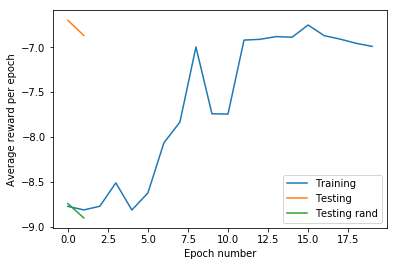

In [128]:
plt.plot(episode_reward_train, label='Training')
plt.plot(episode_reward_test, label='Testing')
plt.plot(episode_reward_rand, label='Testing rand')

plt.xlabel('Epoch number')
plt.ylabel('Average reward per epoch')
plt.legend()

last_n = 10
train_avg = np.mean(np.array(episode_reward_train)[-last_n:])
test_avg = np.mean(np.array(episode_reward_test)[-last_n:])
rand_avg = np.mean(np.array(episode_reward_rand)[-last_n:])

print("Average reward for last", last_n, "epochs in training:", round(train_avg, 3))
print("Average reward for last", last_n, "epochs in testing:", round(test_avg, 3))
print("Average reward for last", last_n, "epochs in testing random policy:", round(rand_avg, 3))

Average length for last 10 epochs in training: 7.983
Average length for last 10 epochs in testing: 7.785
Average length for last 10 epochs in testing random policy: 9.82


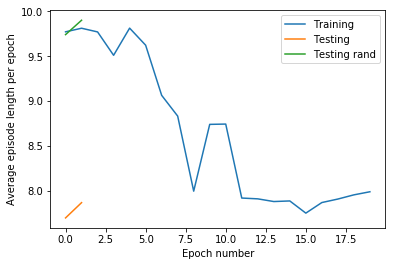

In [129]:
plt.plot(episode_length_train, label='Training')
plt.plot(episode_length_test, label='Testing')
plt.plot(episode_length_rand, label='Testing rand')

plt.xlabel('Epoch number')
plt.ylabel('Average episode length per epoch')
plt.legend()

train_avg = np.mean(np.array(episode_length_train)[-last_n:])
test_avg = np.mean(np.array(episode_length_test)[-last_n:])
rand_avg = np.mean(np.array(episode_length_rand)[-last_n:])

print("Average length for last", last_n, "epochs in training:", round(train_avg, 3))
print("Average length for last", last_n, "epochs in testing:", round(test_avg, 3))
print("Average length for last", last_n, "epochs in testing random policy:", round(rand_avg, 3))

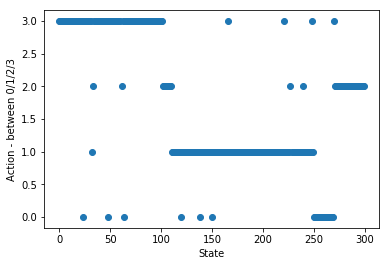

In [11]:
xs = range(300)

policy = make_epsilon_greedy_policy(estimator, 0.1, actions)
ys = [np.random.choice(np.arange(actions), p=policy(i)) for i in xs]

plt.scatter(xs, ys)
plt.xlabel("State")
plt.ylabel("Action - between 0/1/2/3")

In [130]:
state = [100, 1.1, 4.5, 0.02]

estimator.predict(state)

array([-8.4204427 , -8.43165463, -8.28855891, -8.46900378, -8.3975988 ,
       -7.33828428])

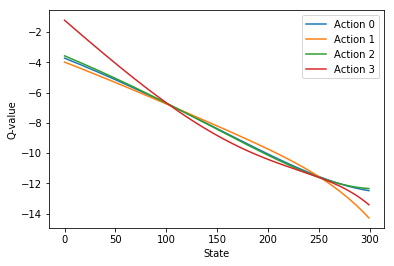

In [13]:
# plt.figure(figsize=(10, 12))

q_values = np.array([estimator.predict(s) for s in xs])

for i in range(actions):
    plt.plot(q_values[:, i], label='Action '+str(i))

plt.legend()
plt.xlabel('State')
plt.ylabel('Q-value')

Testing time taken to use a heuristic

In [88]:
import time

heuristic = jw_2
directory = '../Tests/SATLIB_20/'
files = os.listdir(directory)
files = list(map(lambda x: os.path.join(directory, x), files))

split = int(len(files) * 0.1)
training_files = files[:split]

total_time = 0

for file in training_files:
    env = Env(file)
    env.reset()
    a, b, c = env.state
    
    s = time.time()
    for _ in range(1000):
        heuristic(a, b)
    e = time.time()
    total_time += (e - s) / 1000
    
print(total_time / split)

0.00011689195871353151


In [ ]:
{0: 'maxo', 1: 'moms', 2: 'mams', 3: 'jw', 4: 'jw_2', 5: 'bohm'}